In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape

In [ ]:
def convert_to_binary_mask(mask_array):
    magenta = np.array([255, 0, 255])
    binary_mask = np.all(mask_array == magenta, axis=-1).astype(np.float32)
    return np.expand_dims(binary_mask, axis=-1)


In [63]:
#Image Paths
train_images_dir = './data_road_224/training/image_2'
train_masks_dir  = './data_road_224/training/gt_image_2'

In [64]:
#Sorting
image_files = sorted(os.listdir(train_images_dir))
mask_files  = sorted(os.listdir(train_masks_dir))

In [65]:
X = []
Y = []
for img_file, mask_file in zip(image_files, mask_files):
    img = Image.open(os.path.join(train_images_dir, img_file))
    img = img.resize((224, 224)) 
    img_array = np.array(img) / 255.0 
    
    mask = Image.open(os.path.join(train_masks_dir, mask_file))
    mask = mask.resize((224, 224))
    mask_array = np.array(mask).astype(np.uint8)
    binary_mask = convert_to_binary_mask(mask_array) 
    
    X.append(img_array)
    Y.append(binary_mask)

In [66]:
#Lists to numpy arrays
X = np.array(X)
Y = np.array(Y)
print(f"Loaded {X.shape[0]} images and {Y.shape[0]} masks.")

Loaded 289 images and 289 masks.


In [67]:
# Split into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 231, Validation samples: 58


In [68]:
model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(224 * 224, activation='sigmoid'),
    Reshape((224, 224, 1))
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50176)          │    51,430,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 224, 224, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,285,120 (588.55 MB)

 Trainable params: 154,285,120 (588.55 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=8,
                    validation_data=(X_val, Y_val))

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9277 - loss: 0.1607 - val_accuracy: 0.9353 - val_loss: 0.1461
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9332 - loss: 0.1523 - val_accuracy: 0.9375 - val_loss: 0.1410
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9315 - loss: 0.1520 - val_accuracy: 0.9393 - val_loss: 0.1379
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9380 - loss: 0.1412 - val_accuracy: 0.9416 - val_loss: 0.1316
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.9379 - loss: 0.1379 - val_accuracy: 0.9451 - val_loss: 0.1306


In [72]:
# Predict on validation images
preds = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 892ms/step


In [73]:
#Test Images
test_images_dir  = './data_road_224/testing/image_2/'
test_images = sorted(os.listdir(test_images_dir))

In [74]:
all_entries = os.listdir(test_images_dir)
test_images = [
    entry for entry in all_entries
    if os.path.isfile(os.path.join(test_images_dir, entry))
    and entry.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
]

X_test = []
for img_file in test_images:
    img_path = os.path.join(test_images_dir, img_file)
    img = Image.open(img_path)
    img = img.resize((224, 224))  
    img_array = np.array(img) / 255.0 
    X_test.append(img_array)

print(f"Successfully loaded {len(X_test)} images into X_test.")

Successfully loaded 290 images into X_test.


In [75]:
#Test List to numpy array
X_test = np.array(X_test)

In [76]:
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 751ms/step


In [77]:
# Binarize predictions for visualization
pred_binary = (predictions > 0.5).astype(np.uint8)

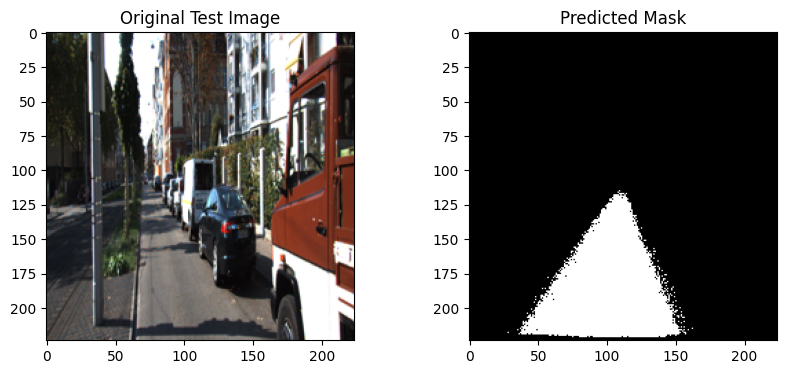

In [78]:
import random
idx = random.randint(0, len(X_test)-1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(X_test[idx])
plt.title("Original Test Image")

plt.subplot(1,2,2)
plt.imshow(pred_binary[idx].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.show()

In [79]:
#Manual Image Uploading
image_path = './Testing_Images/test3.png'

In [80]:
img = Image.open(image_path).resize((224, 224))
img_array = np.array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)

In [81]:
# Prediction
pred_mask = model.predict(img_array)
pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


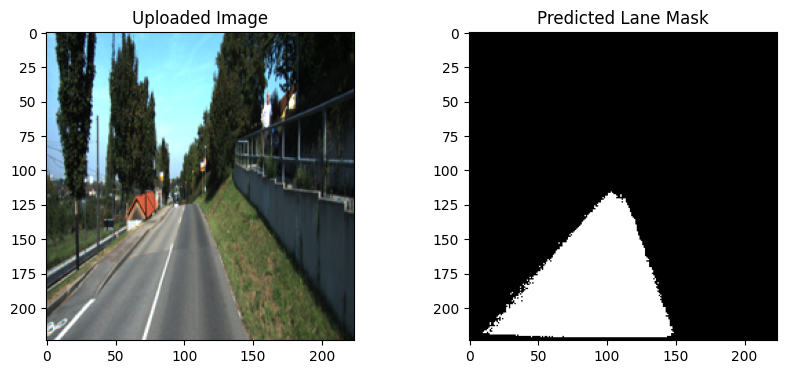

In [82]:
#Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Uploaded Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_binary[0].squeeze(), cmap='gray')
plt.title("Predicted Lane Mask")

plt.show()

In [37]:
from keras.saving import save_model
save_model(model, 'lane_detection.h5')

In [84]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save to file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmphspz93va\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmphspz93va\assets


Saved artifact at 'C:\Users\hp\AppData\Local\Temp\tmphspz93va'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None)
Captures:
  2296604154688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604154512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604526544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604526368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604528480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604528128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604694656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604694480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604696416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296604783536: TensorSpec(shape=(), dtype=tf.resource, name=Non